In [1]:
import kagglehub as kg
path = kg.dataset_download("khsamaha/aviation-accident-database-synopses")

In [2]:
encoding = 'Windows-1252'
with open(path + '/AviationData.csv', 'r', encoding=encoding) as f:
    data = f.read()

with open('AviationData_utf8.csv', 'w', encoding='utf-8') as f:
    f.write(data)

In [3]:
import pandas as pd
base_df = pd.read_csv('AviationData_utf8.csv', low_memory=False)
df = base_df.copy(deep=True)
# Having base_df and df allow me to compare manipulated data (df) against the original dataset (base_df)

In [4]:
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

## EDA and Data Cleaning
First, I want to get a sense of the dataset itself and what transformations and cleaning may need to be done to get it in a workable format. 

From looking at the columns of the dataset, certain columns have a relatively large proportion of null values (e.g., latitutde and longitude; airport name; and air carrier).

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

In [6]:
df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,82805.000000,77488.000000,76379.000000,76956.000000,82977.000000
mean,1.146585,0.647855,0.279881,0.357061,5.325440
std,0.446510,5.485960,1.544084,2.235625,27.913634
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


Let's narrow our focus to traffic in the U.S. only.

In [7]:
df = df[df['Country'] == 'United States']

### Dropping Unhelpful Columns
I'm choosing to drop columns which are of limited use for my purposes here, e.g. those with redundant info (lat./long. when I already have location) and report status (string-based narrative data).

In [9]:
df.drop(['Latitude','Longitude','Investigation.Type',
         'Publication.Date','FAR.Description'],axis=1,inplace=True)

### Event Date
Event.Date column is not in datetime format, I'll correct this.

In [10]:
type(df['Event.Date'][1])

str

In [11]:
df['Event.Date'] = pd.to_datetime(df['Event.Date'])

In [12]:
type(df['Event.Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [32]:
df['Event.Date'].dt.year.value_counts().sort_index(ascending=True)

1948       1
1962       1
1974       1
1977       1
1979       2
1981       1
1982    3318
1983    3237
1984    3190
1985    2882
1986    2644
1987    2617
1988    2494
1989    2323
1990    2278
1991    2219
1992    2052
1993    2041
1994    1981
1995    1993
1996    1900
1997    1839
1998    1830
1999    1845
2000    1798
2001    1677
2002    1647
2003    1715
2004    1581
2005    1622
2006    1446
2007    1594
2008    1485
2009    1363
2010    1364
2011    1382
2012    1356
2013    1162
2014    1119
2015    1130
2016    1166
2017    1142
2018    1154
2019    1128
2020     987
2021    1067
2022    1131
Name: Event.Date, dtype: int64

The core of this dataset appears to consist of entries from 1982 onwards, I will filter the earlier ones out.

In [33]:
df = df[df['Event.Date'].dt.year >= 1982]

In [34]:
df['Event.Date'].dt.year.value_counts().sort_index(ascending=True)

1982    3318
1983    3237
1984    3190
1985    2882
1986    2644
1987    2617
1988    2494
1989    2323
1990    2278
1991    2219
1992    2052
1993    2041
1994    1981
1995    1993
1996    1900
1997    1839
1998    1830
1999    1845
2000    1798
2001    1677
2002    1647
2003    1715
2004    1581
2005    1622
2006    1446
2007    1594
2008    1485
2009    1363
2010    1364
2011    1382
2012    1356
2013    1162
2014    1119
2015    1130
2016    1166
2017    1142
2018    1154
2019    1128
2020     987
2021    1067
2022    1131
Name: Event.Date, dtype: int64

### Air Carrier
Of the air carrier values with non-null entries , it seems that the values are a mix of established carriers (e.g., American, United) which are likely to be helpful in my analysis and other values (e.g., YOUNGBLOOD LARRY J) which are likely to be less helpful when looking at commercial aviation.

In [36]:
df['Air.carrier'].str.title().value_counts()

Pilot                                      192
United Airlines                             68
American Airlines                           66
Southwest Airlines Co                       44
Delta Air Lines                             40
                                          ... 
Jay B. Kurtz                                 1
Apoka Aviation And Flight Services           1
Send North                                   1
Christiansen Lake Rentals & Maintenance      1
Precision Ag & Seed Services Llc             1
Name: Air.carrier, Length: 10731, dtype: int64

I want to eliminate as much duplication of air carriers that results from case sensitivity.

In [15]:
df['Air.carrier'] = df['Air.carrier'].str.title()

### Aircraft Make and Model
I see that Aircraft Make is likely to be a problem. For example, "Cessna" and "CESSNA" both appear here -- I will standardize the cases.

In [16]:
df.value_counts('Make')

Make
Cessna      21573
Piper       11661
CESSNA       4280
Beech        4167
PIPER        2507
            ...  
Mini Ace        1
Mini-MAX        1
Minicab         1
Minkler         1
1200            1
Length: 8001, dtype: int64

In [17]:
df['Make'].str.title().value_counts()

Cessna               25853
Piper                14168
Beech                 5059
Bell                  2285
Boeing                1485
                     ...  
Webb                     1
Moni                     1
Witzel                   1
Martin Curtis            1
Robert J. Labonte        1
Name: Make, Length: 7404, dtype: int64

By converting all strings in the Make column to the same case, 337 erroneously separated values were consolidated and the count of "Cessna" increased by ~74%. I'll permanently convert this column to title case and check if the same issue exists in the Model column.

In [18]:
df['Make'] = df['Make'].str.title()

In [19]:
df['Model'].value_counts()

152                2323
172                1637
172N               1136
PA-28-140           910
150                 790
                   ... 
DH-82C                1
NA-1                  1
SCIRROCO MJ5-K2       1
BARNETT J4B2          1
VARI- EZE             1
Name: Model, Length: 11443, dtype: int64

In [20]:
df['Model'].str.title().value_counts()

152                2323
172                1637
172N               1136
Pa-28-140           910
150                 790
                   ... 
Delta Jet-Ii          1
Hawk Mkii             1
Vans Acft Rv8A        1
Oh- 58C               1
Ela 07 Scorpion       1
Name: Model, Length: 10786, dtype: int64

Converting cases wasn't as impactful for the Model column, likely because Model values are more likely to be numeric in nature. Nonetheless, it decreased the number of unique values by ~5%, so I'll convert to title case.

In [21]:
df['Model'] = df['Model'].str.title()

### Location
I'll standardize the case for location as well.

In [22]:
df['Location'] = df['Location'].str.title()

### Amateur vs Commercial Aircraft
This analysis should only focus on commercial aviation, so I'll exclude any amateur-built aircraft.

In [23]:
df.value_counts('Amateur.Built')

Amateur.Built
No     73906
Yes     8321
dtype: int64

In [24]:
df = df[df['Amateur.Built'] == 'No'].reset_index().drop(['index'], axis=1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73906 entries, 0 to 73905
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                73906 non-null  object        
 1   Accident.Number         73906 non-null  object        
 2   Event.Date              73906 non-null  datetime64[ns]
 3   Location                73896 non-null  object        
 4   Country                 73906 non-null  object        
 5   Airport.Code            44033 non-null  object        
 6   Airport.Name            46285 non-null  object        
 7   Injury.Severity         73798 non-null  object        
 8   Aircraft.damage         71949 non-null  object        
 9   Aircraft.Category       24697 non-null  object        
 10  Registration.Number     73856 non-null  object        
 11  Make                    73897 non-null  object        
 12  Model                   73891 non-null  object

### Aircraft Category
Aircraft category has a low number of non-null values when compared to the total number of entries. I will investigate how best to clean this data, though I doubt I will be able to correct every null value.

In [54]:
null_aircraft_category = df[df['Aircraft.Category'].isna()]
null_aircraft_category

,Event.Id,Accident.Number,Event.Date,Location,Country,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,...,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status
9,20020909X01560,MIA82DA029,1982-01-01,"Jacksonville, Fl",United States,JAX,JACKSONVILLE INTL,Non-Fatal,Substantial,NaN,...,NaN,Personal,NaN,0.0,0.0,3.0,0.0,IMC,Cruise,Probable Cause
10,20020909X01559,FTW82DA034,1982-01-01,"Hobbs, Nm",United States,NaN,NaN,Non-Fatal,Substantial,NaN,...,NaN,Personal,NaN,0.0,0.0,0.0,1.0,VMC,Approach,Probable Cause
11,20020909X01558,ATL82DKJ10,1982-01-01,"Tuskegee, Al",United States,NaN,TUSKEGEE,Non-Fatal,Substantial,NaN,...,NaN,Personal,NaN,0.0,0.0,0.0,1.0,VMC,Landing,Probable Cause
81,20020917X01907,DCA82AA011,1982-01-13,"Washington, Dc",United States,NaN,WASHINGTON NATIONAL,Fatal(78),Destroyed,NaN,...,SCHD,Unknown,"Air Florida, Inc",78.0,6.0,3.0,0.0,IMC,Takeoff,Probable Cause
86,20020917X02486,NYC82DA022,1982-01-15,"Butler, Pa",United States,3G9,BUTLER ROE,Non-Fatal,Substantial,NaN,...,NaN,Personal,NaN,NaN,NaN,NaN,2.0,VMC,Approach,Probable Cause
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73900,20221222106486,CEN23LA068,2022-12-21,"Reserve, La",United States,NaN,NaN,Minor,NaN,NaN,...,NaN,Instructional,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN
73901,20221227106491,ERA23LA093,2022-12-26,"Annapolis, Md",United States,NaN,NaN,Minor,NaN,NaN,...,NaN,Personal,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN
73902,20221227106494,ERA23LA095,2022-12-26,"Hampton, Nh",United States,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
73904,20221227106498,WPR23LA076,2022-12-26,"Morgan, Ut",United States,NaN,NaN,NaN,NaN,NaN,...,NaN,Personal,Mc Cessna 210N Llc,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [55]:
null_aircraft_category.columns

Index(['Event.Id', 'Accident.Number', 'Event.Date', 'Location', 'Country',
       'Airport.Code', 'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'Schedule',
       'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status'],
      dtype='object')

In [56]:
null_aircraft_category['Engine.Type'].value_counts()

Reciprocating    41761
Turbo Shaft       2124
Turbo Prop        1916
Turbo Fan         1387
Unknown           1184
Turbo Jet          506
Name: Engine.Type, dtype: int64

I suspect that engine type will be the best proxy of the existing columns for Aircraft Category. After doing some initial research, I can immediately classify all aircraft with turbo shaft as helicopters and all turbo prop, turbo fan, and turbo jet engines as airplanes. 

In [77]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type'] == 'Turbo Shaft'), 'Aircraft.Category'] = 'Helicopter'

In [79]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type'] == 'Turbo Prop'), 'Aircraft.Category'] = 'Airplane'

In [80]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type'] == 'Turbo Jet'), 'Aircraft.Category'] = 'Airplane'

In [83]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type'] == 'Turbo Fan'), 'Aircraft.Category'] = 'Airplane'

In [88]:
df.loc[(df['Aircraft.Category'].isna())]['Engine.Type'].value_counts()

Reciprocating    41761
Unknown           1184
Name: Engine.Type, dtype: int64

Unfortunately, both airplanes and helicopters can have reciprocating engines, so those entries cannot be immediately reclassified. In the rest of the dataset, there are 1210 entries of helicopters with reciprocating engines and 17387 entries of airplanes with reciprocating engines.

In [59]:
len(df[(df['Engine.Type'] =='Reciprocating') & (df['Aircraft.Category']=='Airplane')])

17387

In [52]:
len(df[(df['Engine.Type'] =='Reciprocating') & (df['Aircraft.Category']=='Helicopter')])

1210

In [90]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type']=='Reciprocating')]['Make'].value_counts()

Cessna               17754
Piper                 9667
Beech                 3120
Mooney                 893
Grumman                850
                     ...  
American Aircraft        1
Infinity                 1
Universal                1
Nanchang China           1
Heli-Eagle Inc.          1
Name: Make, Length: 500, dtype: int64

Luckily, we can further eliminate some NaNs from the aircraft category using aircraft make now.
After further research, I have discovered that Piper, Beech, and Mooney have never made helicopters. Cessna only ever made one helicopter model (the CH-1 Skyhook).  I will check for Skyhooks before seeting all Cessnas to 'Airplane'

In [97]:
df.loc[(df['Aircraft.Category'].isna()) &       
       (df['Engine.Type']=='Reciprocating') &
       (df['Make'] == 'Cessna') &
       (df['Model'].apply(lambda x: isinstance(x, str) and re.search(r'ch|skyhook', x, re.IGNORECASE) is not None))]

,Event.Id,Accident.Number,Event.Date,Location,Country,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,...,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status


Seeing no relevant Cessna entries with that name, I will set the aircraft category for each of the above to 'Airplane'.

In [98]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Cessna'), 'Aircraft.Category'] = 'Airplane'

In [99]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Piper'), 'Aircraft.Category'] = 'Airplane'

In [100]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Beech'), 'Aircraft.Category'] = 'Airplane'

In [101]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Mooney'), 'Aircraft.Category'] = 'Airplane'

### Registration Numbers with Multiple Incidents

In [151]:
percent_multiple = (len(df['Registration.Number'])-len(df['Registration.Number'].unique()))/len(df['Registration.Number'])
print(f'Approximately {round(percent_multiple*100,2)}% of aircraft in the dataframe have hade more than one incident recorded.')

Approximately 4.41% of aircraft in the dataframe have hade more than one incident recorded.


Around 4% of aircraft in the dataframe have had more than one incident recorded. It could be interesting to see what, if anything, is happening differently with those aircraft.

In [39]:
multi_incident_aircraft = [x for x in df['Registration.Number'].unique() if df['Registration.Number'].value_counts().get(x,0) >1]

In [89]:
multi_incident_df = df[df['Registration.Number'].isin(multi_incident_aircraft)]

In [152]:
multi_incident_df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,1532.000000,1420.000000,1431.000000,1441.000000,1654.000000
mean,1.127285,0.249296,0.248777,0.181818,8.514510
std,0.374026,3.048093,1.723437,0.980492,35.073781
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,4.000000,112.000000,53.000000,27.000000,380.000000


In [153]:
df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,21866.000000,21651.000000,21571.000000,21855.000000,23699.000000
mean,1.178542,0.692301,0.304112,0.237795,7.072071
std,0.428836,6.305217,2.222186,1.689566,33.701013
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,295.000000,161.000000,200.000000,588.000000


### Concluding EDA
After going through some initial exploration and cleaning of the data, we are down to 24417 entires. These reflect a population of incidents which are more useful for understanding the safety challenges of general and commercial aviation.

## Initial Thoughts
From looking at the columns, there are a lot of columns with relatively high null values.  For example, Air.carrier

Which aircraft saw the biggest drops in fatalities over the years? <br>
Did any aircraft see an increase in fatalities over the years? <br>

### Visualizations:
Total crashes over time <br>
Geographic plot of crashes



### High-Level Summary Statistics

In [188]:
base_df['Event.Date'].dt.year.value_counts().sort_index(ascending=True)

1948       1
1962       1
1974       1
1977       1
1979       2
1981       1
1982    3593
1983    3556
1984    3457
1985    3096
1986    2880
1987    2828
1988    2730
1989    2544
1990    2518
1991    2462
1992    2355
1993    2313
1994    2257
1995    2309
1996    2187
1997    2148
1998    2226
1999    2209
2000    2220
2001    2063
2002    2020
2003    2085
2004    1952
2005    2031
2006    1851
2007    2016
2008    1893
2009    1783
2010    1786
2011    1850
2012    1835
2013    1561
2014    1535
2015    1582
2016    1664
2017    1638
2018    1681
2019    1624
2020    1392
2021    1545
2022    1607
Name: Event.Date, dtype: int64

In [212]:
df['Event.Date'].dt.year.value_counts().sort_index(ascending=True)

1979       1
1982    2954
1983      10
1984       7
1985       6
1986       8
1987       3
1988       8
1989       7
1990      19
1991      14
1992       5
1993       6
1994       5
1995       7
1996       7
1997      17
1998       6
1999      11
2000      12
2001      24
2002      50
2003     133
2004     420
2005     605
2006     611
2007     820
2008    1279
2009    1127
2010    1163
2011    1189
2012    1122
2013     970
2014     932
2015     962
2016    1011
2017     977
2018     981
2019     961
2020     857
2021     898
2022     916
Name: Event.Date, dtype: int64

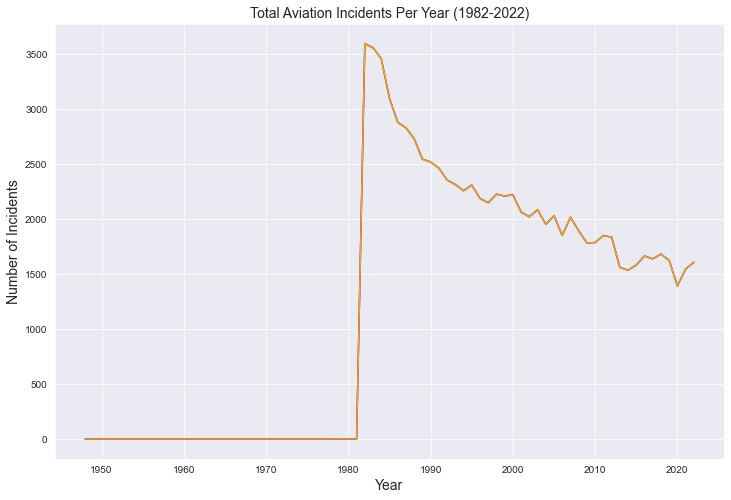

In [245]:
# Total Incidents Per Year
base_df['Event.Date'] = pd.to_datetime(base_df['Event.Date'])
dates = base_df['Event.Date'].value_counts().sort_index(ascending=True)
airplane_dates = df['Event.Date'].value_counts().sort_index(ascending=True)
# Dropping some index values for years with very low counts to make the plot more legible
#dates_to_drop = pd.to_datetime(['1948-10-24', '1962-07-19','1974-08-30', '1977-06-19', '1979-08-02', '1979-09-17','1981-08-01',])
#dates.drop(index=dates_to_drop,inplace=True)

import seaborn as sns

fig,ax=plt.subplots(figsize=(12,8))

total_counts = dates.groupby(dates.index.year).sum()
airplane_counts = airplane_dates.groupby(airplane_dates.index.year).sum()
total_years = total_counts.index
airplane_years = airplane_counts.index

sns.set_style('darkgrid')

ax.plot(years, total_counts, label='Total Incidents', color='blue')
ax.plot(airplane_years, airplane_counts, label='Airplane Incidents', color='orange')
ax.set_title('Total Aviation Incidents Per Year (1982-2022)', fontsize=14)
ax.set_ylabel('Number of Incidents', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.show()

In [253]:
df[df['Aircraft.Category'].isna()]['Make']

0            Stinson
1              Piper
2             Cessna
3           Rockwell
4             Cessna
            ...     
88883    AIR TRACTOR
88884          PIPER
88885       BELLANCA
88887         CESSNA
88888          PIPER
Name: Make, Length: 56602, dtype: object

In [250]:
df[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Cessna')]['Aircraft.Category'].fillna('Airplane',inplace=True)